# Replication Exercise

In this exercise we show the validity of the package in replicating Phillips et al. (2015).

We download the CAPE data from the [Shiller website](https://shillerdata.com/) to perform the exercise.

In [1]:
import pandas as pd

url: str = (
    "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/02d69a38-97f2-45f8-941d-4e4c5b50dea7/ie_data.xls?ver=1743773003799"
)

data: pd.DataFrame = (
    pd.read_excel(
        url,
        sheet_name="Data",
        skiprows=7,
        usecols=["Date", "P", "D", "E", "CAPE"],
        skipfooter=1,
        dtype={"Date": str, "P": float},
    )
    .rename(
        {
            "P": "sp500",
            "CAPE": "cape",
            "Date": "date",
            "D": "dividends",
            "E": "earnings",
        },
        axis=1,
    )
    .assign(
        date=lambda x: pd.to_datetime(x["date"].str.ljust(7, "0"), format="%Y.%m"),
    )
    .set_index("date", drop=True)
)

We look for the existence of bubbles in the Price-Dividend ratio.


In [2]:
pdratio: pd.Series = data["sp500"] / data["dividends"]
pdratio = pdratio.dropna()

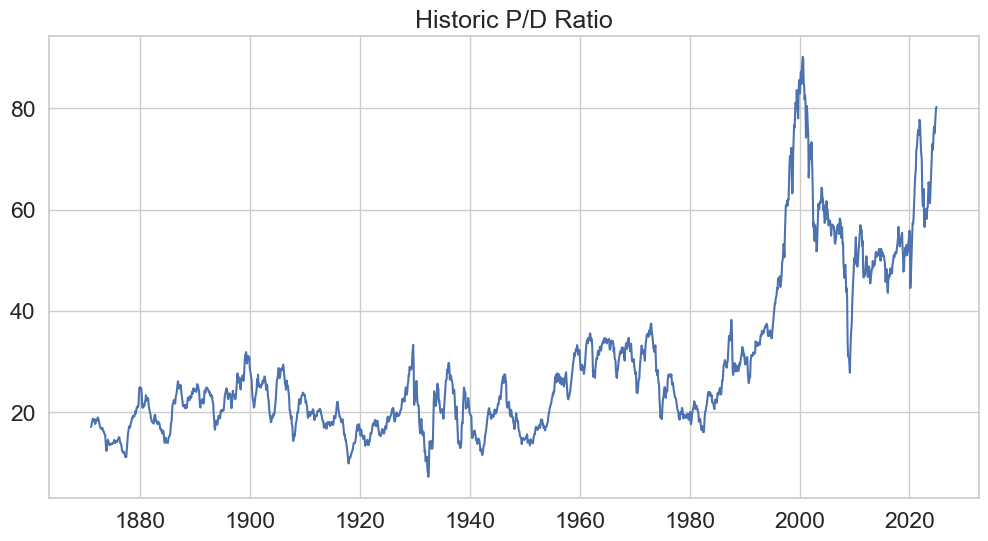

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    rc={"figure.figsize": (12, 6)},
)

plt.plot(pdratio)
plt.title("Historic P/D Ratio")
plt.show()

Using the `psytest` package, we first initialize the object using the `PSYBubbles` function.


In [4]:
from psytest import PSYBubbles
from numpy import datetime64

psy: PSYBubbles[datetime64] = PSYBubbles.from_pandas(
    data=pdratio, minwindow=None, lagmax=0, minlength=None
)

Then we calculate the test statistics and critical values. We will be using a significance level of 5% using the available tabulated data by setting `fast=True`.


In [5]:
stat: dict[datetime64, float] = psy.teststat()
cval: dict[datetime64, float] = psy.critval(test_size=0.05, fast=True)

Using these objects, we find the occurances of bubbles in the data:


In [6]:
bubbles: list[tuple[datetime64, datetime64 | None]] = psy.find_bubbles(alpha=0.05)

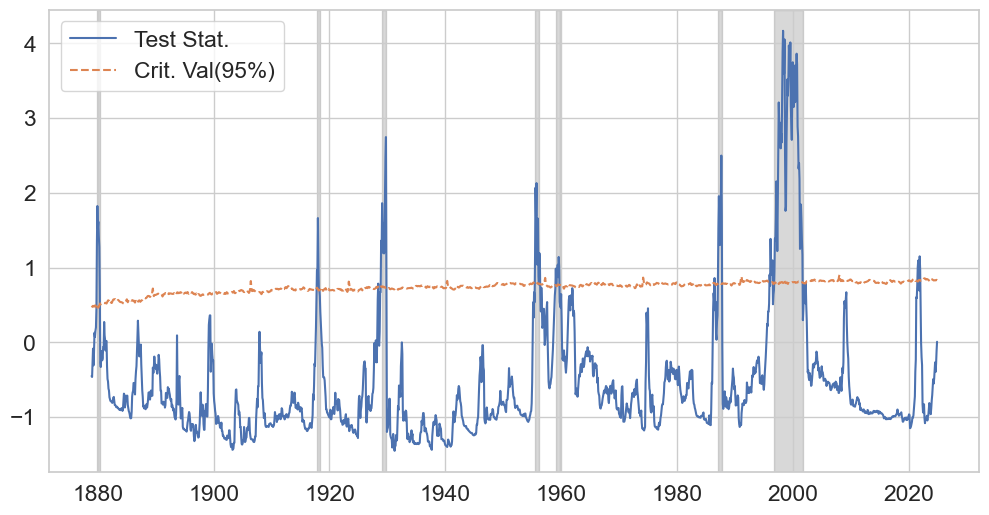

In [7]:
plt.plot(stat.keys(), stat.values(), label="Test Stat.")
plt.plot(cval.keys(), cval.values(), linestyle="--", label="Crit. Val(95%)")
for bubble in bubbles:
    plt.axvspan(
        bubble[0],
        bubble[1] if bubble[1] is not None else pdratio.index[-1],
        color="gray",
        alpha=0.3,
        zorder=-1,
    )
plt.legend()
plt.show()

In [8]:
bubbles_table: pd.DataFrame = pd.DataFrame(bubbles, columns=["start", "end"]).assign(
    duration=lambda x: x["end"] - x["start"],
)
bubbles_table

,start,end,duration
0,1879-11-01,1880-06-01,213 days
1,1917-11-01,1918-05-01,181 days
2,1929-01-01,1929-11-01,304 days
3,1955-07-01,1956-03-01,244 days
4,1959-02-01,1959-10-01,242 days
5,1987-02-01,1987-11-01,273 days
6,1996-11-01,2001-10-01,1795 days


Which match with the ones on the original paper (p.p. 1066).